我还是决定试一试，也许1个GPU，1个集成显卡，也可以跑起来呢？？

# 从0开始实现

## 基本代码

### **导入基本的包**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import d2l_torch as d2l

%matplotlib inline

### 定义网络结构和损失函数

In [27]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

In [28]:
print("b1 weight:",b1.device)   # 默认是在cpu里的

b1 weight: cpu


### 分发参数（向多个设备）
+ 默认情况下，什么都不添加/指定的时候，参数变量/tensor应该是存在cpu里的
+ 下面的函数就是使用tensor.to(device)，把参数tensor移到其他设备上

In [23]:
def get_params(params,device):
    new_params=[p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

其中，关于clone函数，参考：<https://pytorch.org/docs/stable/generated/torch.clone.html>
+ This function is differentiable, so gradients will flow back from the result of this operation to input. To create a tensor without an autograd relationship to input see detach().
+ 这个函数是可微的，梯度会从这个操作的结果流回输入。如果想创建一个和输入没有梯度关联关系的，可以使用detach（）

+ 意思就是说，使用clone函数创建的tensor，**梯度和调用它的那个tensor是关联的**。
+ 也可以参考以下：
    + [Pytorch】对比clone、detach以及copy_等张量复制操作](https://blog.csdn.net/guofei_fly/article/details/104486708)
    + <https://zhuanlan.zhihu.com/p/38475183>

另外，关于`requires_grad_` 来自文档：<https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html>
+ 默认是True

+ 另外，其实这个`clone`是可以不写的，因为下面已经对新的参数`new_params`中的参数，指定了`requires_grad_`属性
+ 写上只是因为，如果定义的params参数（旧参数），本来就在gpu0上，那么如果你还to到gpu0上，那么不会有任何操作。
+ 但是如果加上clone，就一定会新生成一个tensor。（也就是保险起见，可以用clone，但是在这个例子中，可以不用）

In [24]:
new_params=get_params(params,d2l.try_gpu(0)) 
print("b1 weight:", new_params[1])
print("b1 grad:", new_params[1].grad)
print("b1 device:", new_params[1].device)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None
b1 device: cuda:0


+ 打印的是第一个卷积层的 偏置 参数，位于params的第2个位置。对应于b1
+ 可以看到，设备位于`cuda:0`，同时是要进行梯度计算的。
+ 但是由于没有进行SGD优化，所以grad还没算

### 同步梯度（allreduce函数）

将所有向量相加，并将结果广播给所有GPU

如果学过高性能计算的话，`allreduce`是一个非常有名的操作。
+ 在所有的设备（GPU）上，有一些梯度（data），把这些梯度全都加起来，再把这个结果赋值回去。

具体的做法是：
+ 如果有4个GPU，先把gpu1、gpu2、gpu3的数据发送到gpu0上去。
+ 然后在gpu0上，把gpu0、1、2、3这四块的数据加起来。（因为相加必须要在1个GPU上进行）
+ 算出结果之后，再把这些结果发送回去。


In [5]:
def allreduce(data):
    """
    data是一个列表，如果有4个GPU，那么data里就有4个元素，每个元素对应一个GPU，但是这个元素的类型是什么，就不是确定的了
    """
    for i in range(1,len(data)): # gpu0以外的其他GPU
        data[0][:]+=data[i].to(data[0].device)  # 当i=1时，把gpu1的数据先挪到和gpu0相同的设备上，再进行相加。
    for i in range(1,len(data)):
        data[i]=data[0].to(data[i].device) # 算完之后，再把gpu0的数据返回给其他参与并行计算的设备。

[:]会在现有的data的内存中修改，没有[:]的话data会再分配一次内存空间；这样可以提高运行和内存效率

In [6]:
d2l.try_gpu(0),d2l.try_gpu(1)

(device(type='cuda', index=0), device(type='cpu'))

In [7]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i+1) for i in range(2)]
print(f"data:\n{data}")  # 有个 i+1,所以输出是1和2 

print('before allreduce:\n', data[0], '\n', data[1])

allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

data:
[tensor([[1., 1.]], device='cuda:0'), tensor([[2., 2.]])]
before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


+ 第一个张量在cuda gpu0上，第二个张量在cpu上
+ 进行allreduce之后，可以看到，data[0]，也就是gpu0上的数据，已经是原先cpu和gpu0上数据的和了；同时cpu上也成了最新的和数据

### 分发数据（一个batch均匀分发）

这里就是举个例子，直接使用torch自带的`nn.parallel.scatter`函数来完成数据的分发操作

In [10]:
data=torch.arange(20).reshape(4,5)
device=[torch.device("cuda:0"),torch.device("cpu")]


# split=nn.parallel.scatter(data,device)

# print('input :', data)
# print('load into', devices)
# print('output:', split)

+ 直接调用torch自带的，会报错：`ValueError: Expected a non cpu device, but got: cpu`\
+ 即：torch框架不支持使用cpu来进行数据并行。（除非自己自定义）
+ 那就自己写个简陋的好了

In [16]:
def self_scatter(data,device):
    num=len(device)
    middle_num=data.shape[0]//2
#     print(f"{middle_num}")
    rs=[data[:middle_num].clone().to(device[0]),data[middle_num:].clone().to(device[1])]
    return rs

参考：
+ [Pytorch.device使用及理解](https://blog.csdn.net/qq_40515250/article/details/111224018)
+ 上面分发参数的时候，使用：`new_params=[p.clone().to(device) for p in params]` 就是参考这句，
+ 写出来：`rs=[data[:middle_num].clone().to(device[0]),data[middle_num:].clone().to(device[1])]`
+ 所以pytorch中张量的赋值，其实很值得研究

In [11]:
data[2:]

tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])

In [15]:
data=torch.arange(20).reshape(4,5)
devices=[torch.device("cuda:0"),torch.device("cpu")]

split=self_scatter(data,devices)

print('input :', data)
print('load into', devices)
print('output:', split)

2
input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cpu')]
output: [tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])]


In [21]:
5//2

2

这个输出结果和老师使用的`nn.parallel.scatter`的输出一样的。

**使用的简洁代码**

In [37]:
def self_scatter(data,device):
    num=len(device)
    middle_num=data.shape[0]//2
    rs=[data[:middle_num].clone().to(device[0]),data[middle_num:].clone().to(device[1])]
    return rs

def split_batch(X,y,devices):
    assert X.shape[0]==y.shape[0]
    return (self_scatter(X,devices),self_scatter(y,devices))

**改进**
+ 在运行**在单个GPU上运行时**报错，因为上面写的太死了，因此改为以下实现

In [40]:
def self_scatter(data,device):
    num_device=len(device)
    num_data=data.shape[0]//num_device
    rs=[data[i*num_data:(i+1)*num_data].clone().to(device[i]) for i in range(num_device)]
    return rs

### 在一个小批量上实现多GPU训练

集群(cluster)、节点(node)和**分片(shards)**

+ 先是`lenet(X_shards,device_params)`得到`y_pred`
+ 然后`loss(y_pred,y_shards)`得到一个设备上的损失
+ 依次得到所有设备上数据分片的损失
+  X_shard,device_w,y_shard是一组，表示一个设备上分得的数据和所有的参数

In [30]:
def train_batch(X,y,device_params,devices,lr):
    X_shards,y_shards=split_batch(X,y,devices)
    loss_value=[loss(lenet(X_shard,device_w), y_shard).sum() for X_shard,y_shard,device_w in zip(X_shards, y_shards, device_params)]
    # 返回每个设备上对应的损失，列表中每个元素对应一个设备的损失
    for l in loss_value:
        l.backward() # 计算l中参数的梯度
    with torch.no_grad():
        for i in range(len(device_params[0])): # device_params[0]表示设备0的参数，len（）表示这个设备中参数是多少层
            allreduce([device_params[c][i].grad for c in range(len(devices)) ]) # c是设备序号 一维是设备号，二维是每个设备中所有层的参数
   
    # 参数分发完成之后，就可以使用sgd来更新参数了
    for param in device_params:
        d2l.sgd(param,lr,X.shape[0])


**弹幕里有人和我有一样的问题**❓❓❓
+ 为什么`allreduce`里要一层一层的添加参数，直接一次添加所有不行吗？？

**回答**
+ 因为你要同步的内容是梯度，而不是单纯的网络参数，要用的是网络参数的梯度，所以只能一个一个的取param.grad

----

`backward()`函数，参考：https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html

```bash
Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)[source]
Computes the gradient of current tensor w.r.t. graph leaves.
```

----
+ 最后一个for循环，其实device_params里包含多个设备的参数，所以如果是2个设备，那么参数就重复出现了1次，也就是会重复计算。。。
+ 所以如果想减少计算量，可以算一次，也就是直接device_params[0]，然后把算出来的梯度再传到其他设备上去。。。

---

d2l.sgd函数中包含梯度清0操作 param.grad.zero_() 所以上面代码里没看到梯度置0操作

可以参考：[3.2. 线性回归的从零开始实现](https://zh-v2.d2l.ai/chapter_linear-networks/linear-regression-scratch.html#id7)

---
+ 另外，代码中， 先算每个设备的损失（for循环），然后再for循环对每个设备上的损失进行求导
+ 看起来就像是串行的
+ 如果框架设计的好，那么会自动帮你并行；如果框架不好，那么这部分代码可能就得不到很好的优化
+ mxnet和tensorflow是没问题的，pytorch在并行上可能有点悬

### 定义训练函数

In [21]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]   
    print(f"devices:{devices}")
    
    
    device_params = [get_params(params, d) for d in devices] 
    # 把初始化之后的参数分发给设备，这样可以保证所有设备初始梯度一致
    # 由于梯度计算也是所有设备梯度加一起算的，所以所有设备backward之后，梯度也一样
    # 则就可以保证所有设备，每次更新后参数/权重都一致
    # 数据并行
    
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()  # cuda同步。。。我一个cpu 一个gpu 应该不行吧  每个gpu任务完成之后，同步一次
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

`device_params = [get_params(params, d) for d in devices] `
+ 把初始化之后的参数分发给设备，这样可以保证所有设备初始梯度一致
+ 由于梯度计算也是所有设备梯度加一起算的，所以所有设备backward之后，梯度也一样
+ 则就可以保证所有设备，每次更新后参数/权重都一致
+ 数据并行

### 在单个GPU上运行

test acc: 0.83, 3.7 sec/epoch on [device(type='cuda', index=0)]


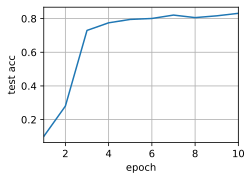

In [41]:
train(num_gpus=1, batch_size=256, lr=0.2)

### 在2个GPU上运行

test acc: 0.83, 16.9 sec/epoch on [device(type='cuda', index=0), device(type='cpu')]


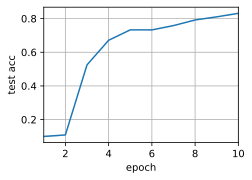

In [42]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 验证试验

### param.clone()验证

这里认真写一下`clone()`这个函数

根据：[【Pytorch】对比clone、detach以及copy_等张量复制操作](https://blog.csdn.net/guofei_fly/article/details/104486708)
+ clone() 返回一个和源张量同shape、dtype和device的张量，与源张量不共享数据内存，但提供梯度的回溯。

In [1]:
def self_scatter(data,device):
    num_device=len(device)
    num_data=data.shape[0]//num_device
    rs=[data[i*num_data:(i+1)*num_data].clone().to(device[i]) for i in range(num_device)]
    return rs

def get_params(params,device):
    new_params=[p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

参考上面两个函数的代码，写出以下测试代码：

In [15]:
data=torch.arange(20, dtype=torch.float32,requires_grad=True).reshape(4,5)
print(f"clone之前data的id为:{id(data)}")

new_data=[p.clone().to(torch.device("cpu")) for p in data]
print(f"clone之后data的id为:{id(data)}\n")
print(f"new_data的id为:{id(new_data)}")
print(f"new_data:\n{new_data}") 

new_data=[p.to(torch.device("cpu")) for p in data]
print(f"\nnew_data不加clone的id为:{id(new_data)}")
print(f"new_data:\n{new_data}") 

clone之前data的id为:2093033317224
clone之后data的id为:2093033317224

new_data的id为:2093076697800
new_data:
[tensor([0., 1., 2., 3., 4.], grad_fn=<CloneBackward>), tensor([5., 6., 7., 8., 9.], grad_fn=<CloneBackward>), tensor([10., 11., 12., 13., 14.], grad_fn=<CloneBackward>), tensor([15., 16., 17., 18., 19.], grad_fn=<CloneBackward>)]

new_data不加clone的id为:2093071036040
new_data:
[tensor([0., 1., 2., 3., 4.], grad_fn=<UnbindBackward>), tensor([5., 6., 7., 8., 9.], grad_fn=<UnbindBackward>), tensor([10., 11., 12., 13., 14.], grad_fn=<UnbindBackward>), tensor([15., 16., 17., 18., 19.], grad_fn=<UnbindBackward>)]


可以看到：
+ 加了clone之后，得到的Tensor的梯度是`grad_fn=<CloneBackward>)`
+ 不加clone的话，得到的Tensor的梯度就是 `grad_fn=<UnbindBackward>),`

检索过程遇到一个写的很好的专栏，分享一下：
+ [PyTorch 源码解读之 torch.autograd：梯度计算详解](https://zhuanlan.zhihu.com/p/321449610)
+ [PyTorch的动态图(上)](https://zhuanlan.zhihu.com/p/61765561)

# 多GPU的简洁实现

这个我基本是可以不用跑的，因为我只有1个GPU，学习学习代码就好了。

## 基本代码

In [2]:
import torch 
from torch import nn
import d2l_torch as d2l

**定义网络，使用简化版的resnet18**
+ 在使用resnet_block的时候，和之前课程直接构成一个列表，传给Sequential不一样
+ 这里使用了`add_module`函数，给每个block起了名字。

可以看一下之前的代码比较一下，
+ <https://zh-v2.d2l.ai/chapter_convolutional-modern/resnet.html>
+ <http://courses.d2l.ai/zh-v2/assets/notebooks/chapter_convolutional-modern/resnet.slides.html#/>

In [8]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的 ResNet-18 模型。"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(in_channels, out_channels, use_1x1conv=True,
                                 strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc",
                   nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

net = resnet18(10)
devices = d2l.try_all_gpus()

**定义训练函数**

In [9]:
def train(net,num_gpus,batch_size,lr):
    train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    def init_weight(m):
        if type(m) in [nn.Linear,nn.Conv2d]:
            nn.init.normal_(m.weight,std=0.01)    
    net.apply(init_weight)
    
    net=nn.DataParallel(net,devices) # 定义数据并行
    
    trainer=torch.optim.SGD(net.parameters(),lr) # 优化器
    loss=nn.CrossEntropyLoss()
    
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')   

+ `net=nn.DataParallel(net,devices) # 定义数据并行` 这句就是，告诉torch，使用的网络是谁，有几个设备，那么torch就会自动帮你把这个net复制到其他的devices上去。
+ 类似之前从0实现的时候，那个get_param（分发参数的操作）

另外，数据部分：
+  X, y = X.to(devices[0]), y.to(devices[0])
+ 由于上面net已经被分发到多个设备了，所以遇到这个数据，其实torch就会自动帮你均匀分到多个设备，但是gpu0会作为主卡（梯度计算加和发生的地方）

## 训练结果

### 在单个GPU上训练

test acc: 0.91, 107.1 sec/epoch on [device(type='cuda', index=0)]


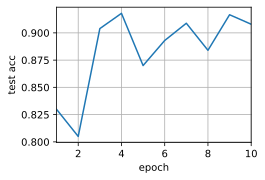

In [10]:
train(net,num_gpus=1,batch_size=256,lr=0.1)

可以看到：
+ 一开始震荡很厉害，这是因为lr比较大
+ 但是没事，主要后面，准确率相对平稳上升就可以

In [13]:
devices = d2l.try_all_gpus()
print(f"{devices}")

[device(type='cuda', index=0)]


### 在多个GPU上训练（不改变参数）

In [14]:
train(net,num_gpus=2,batch_size=256,lr=0.1)

ValueError: Expected a non cpu device, but got: cpu

虽然没有办法训练，但是其实可以看到DP的代码，位于`torch\nn\parallel\data_parallel.py`，内容大概有
```python
                self.dim = dim
    137         self.module = module
--> 138         self.device_ids = list(map(lambda x: _get_device_index(x, True), device_ids))
    139         self.output_device = _get_device_index(output_device, True)
    140         self.src_device_obj = torch.device(device_type, self.device_ids[0])

```

### 在多个GPU上训练（改变参数）

In [ ]:
train(net,num_gpus=2,batch_size=256*2,lr=0.1*2)

在沐神的试验里（正常多个GPU情况下）
+ 改了参数之后（lr和batch_size都变大），数据并行的优势就体现出来了，确实差不多2个GPU比1个GPU快了一倍。但是准确率会有所损失（因为lr的原因）
    + 虽然2个gpu并行时间还是没有达到1个gpu时间的一半
    + 这是因为还是batch_size太小，所以数据传输/通讯的开销，大于计算的开销
    + 而准确率降低，其实是因为对于fashion-mnist这个数据集来说，256*\2的batch_size太大了，梯度计算的时候，会除以batch_size。
    + 这里沐神提出一个东西：
    > **如果数据集很简单，但是batch_size很大，那么每个batch里面可能会有样本非常类似，也就是batch中的数据多样性不够，那么训练的时候，梯度计算其实就有了重复和无意义的计算，这种似乎不好。**
    + 所以以后是否可以手动调节batch里的内容，比如做20分类，每个batch 40张图，那么就让每个类别的图像出现两次？？？
+ 如果不改的话，准确率基本不变，但是时间只会加快一点点